# H2CO molecute - visualize

Visualize trained model

## Environment

In [1]:
# | echo: false
import platform
import sys

import pompon

print(sys.version)
print(f"pompon version = {pompon.__version__}")
print(platform.platform())

3.12.2 (main, Feb  6 2024, 20:19:44) [Clang 15.0.0 (clang-1500.1.0.2.5)]
pompon version = 0.0.9
macOS-14.4.1-arm64-arm-64bit


## Import modules

In [2]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import polars as pl

plt.style.use("seaborn-v0_8-darkgrid")
plt.rcParams.update(
    {
        "image.cmap": "jet",
    }
)

x_train = np.load("data/x_train.npy")
y_train = np.load("data/y_train.npy")
x_scale = x_train.std()
y_scale = y_train.std()
y_shift = -3112.1604302407663  # eV (mean)
y_min = -3113.4044750979383  # eV (eq. position)
print(f"{x_scale=}, {y_scale=}")

x_scale=np.float64(17.203527572055016), y_scale=np.float64(0.4220226766217427)


## Load data

`coef` satisfies
$$
Q_i = c_i q_i
$$

where $Q_i$ is dimensionless, 
$q_i$ is mass-weighted with unit $\sqrt{m_{\mathrm{e}}}\cdot a_0$ 
and 
$$
c_i = \sqrt{\frac{\omega_i}{\hbar}} \times {\left[\sqrt{\frac{\mathrm{AMU}}{m_{\mathrm{e}}}}\frac{\mathring{\mathrm{A}}}{a_0}\right]}
$$

In [3]:
nnmpo = pompon.NNMPO.import_h5("data/nnmpo_final_rmse_8.365e-04.h5")
coef = np.array(
    [0.07374254, 0.07589426, 0.08348098, 0.09213946, 0.11429979, 0.11547274]
)  # * x_scale

2024-10-16 10:47:43 - INFO:pompon.pompon.model - Model is imported from data/nnmpo_final_rmse_8.365e-04.h5


## Visualize 2D cut

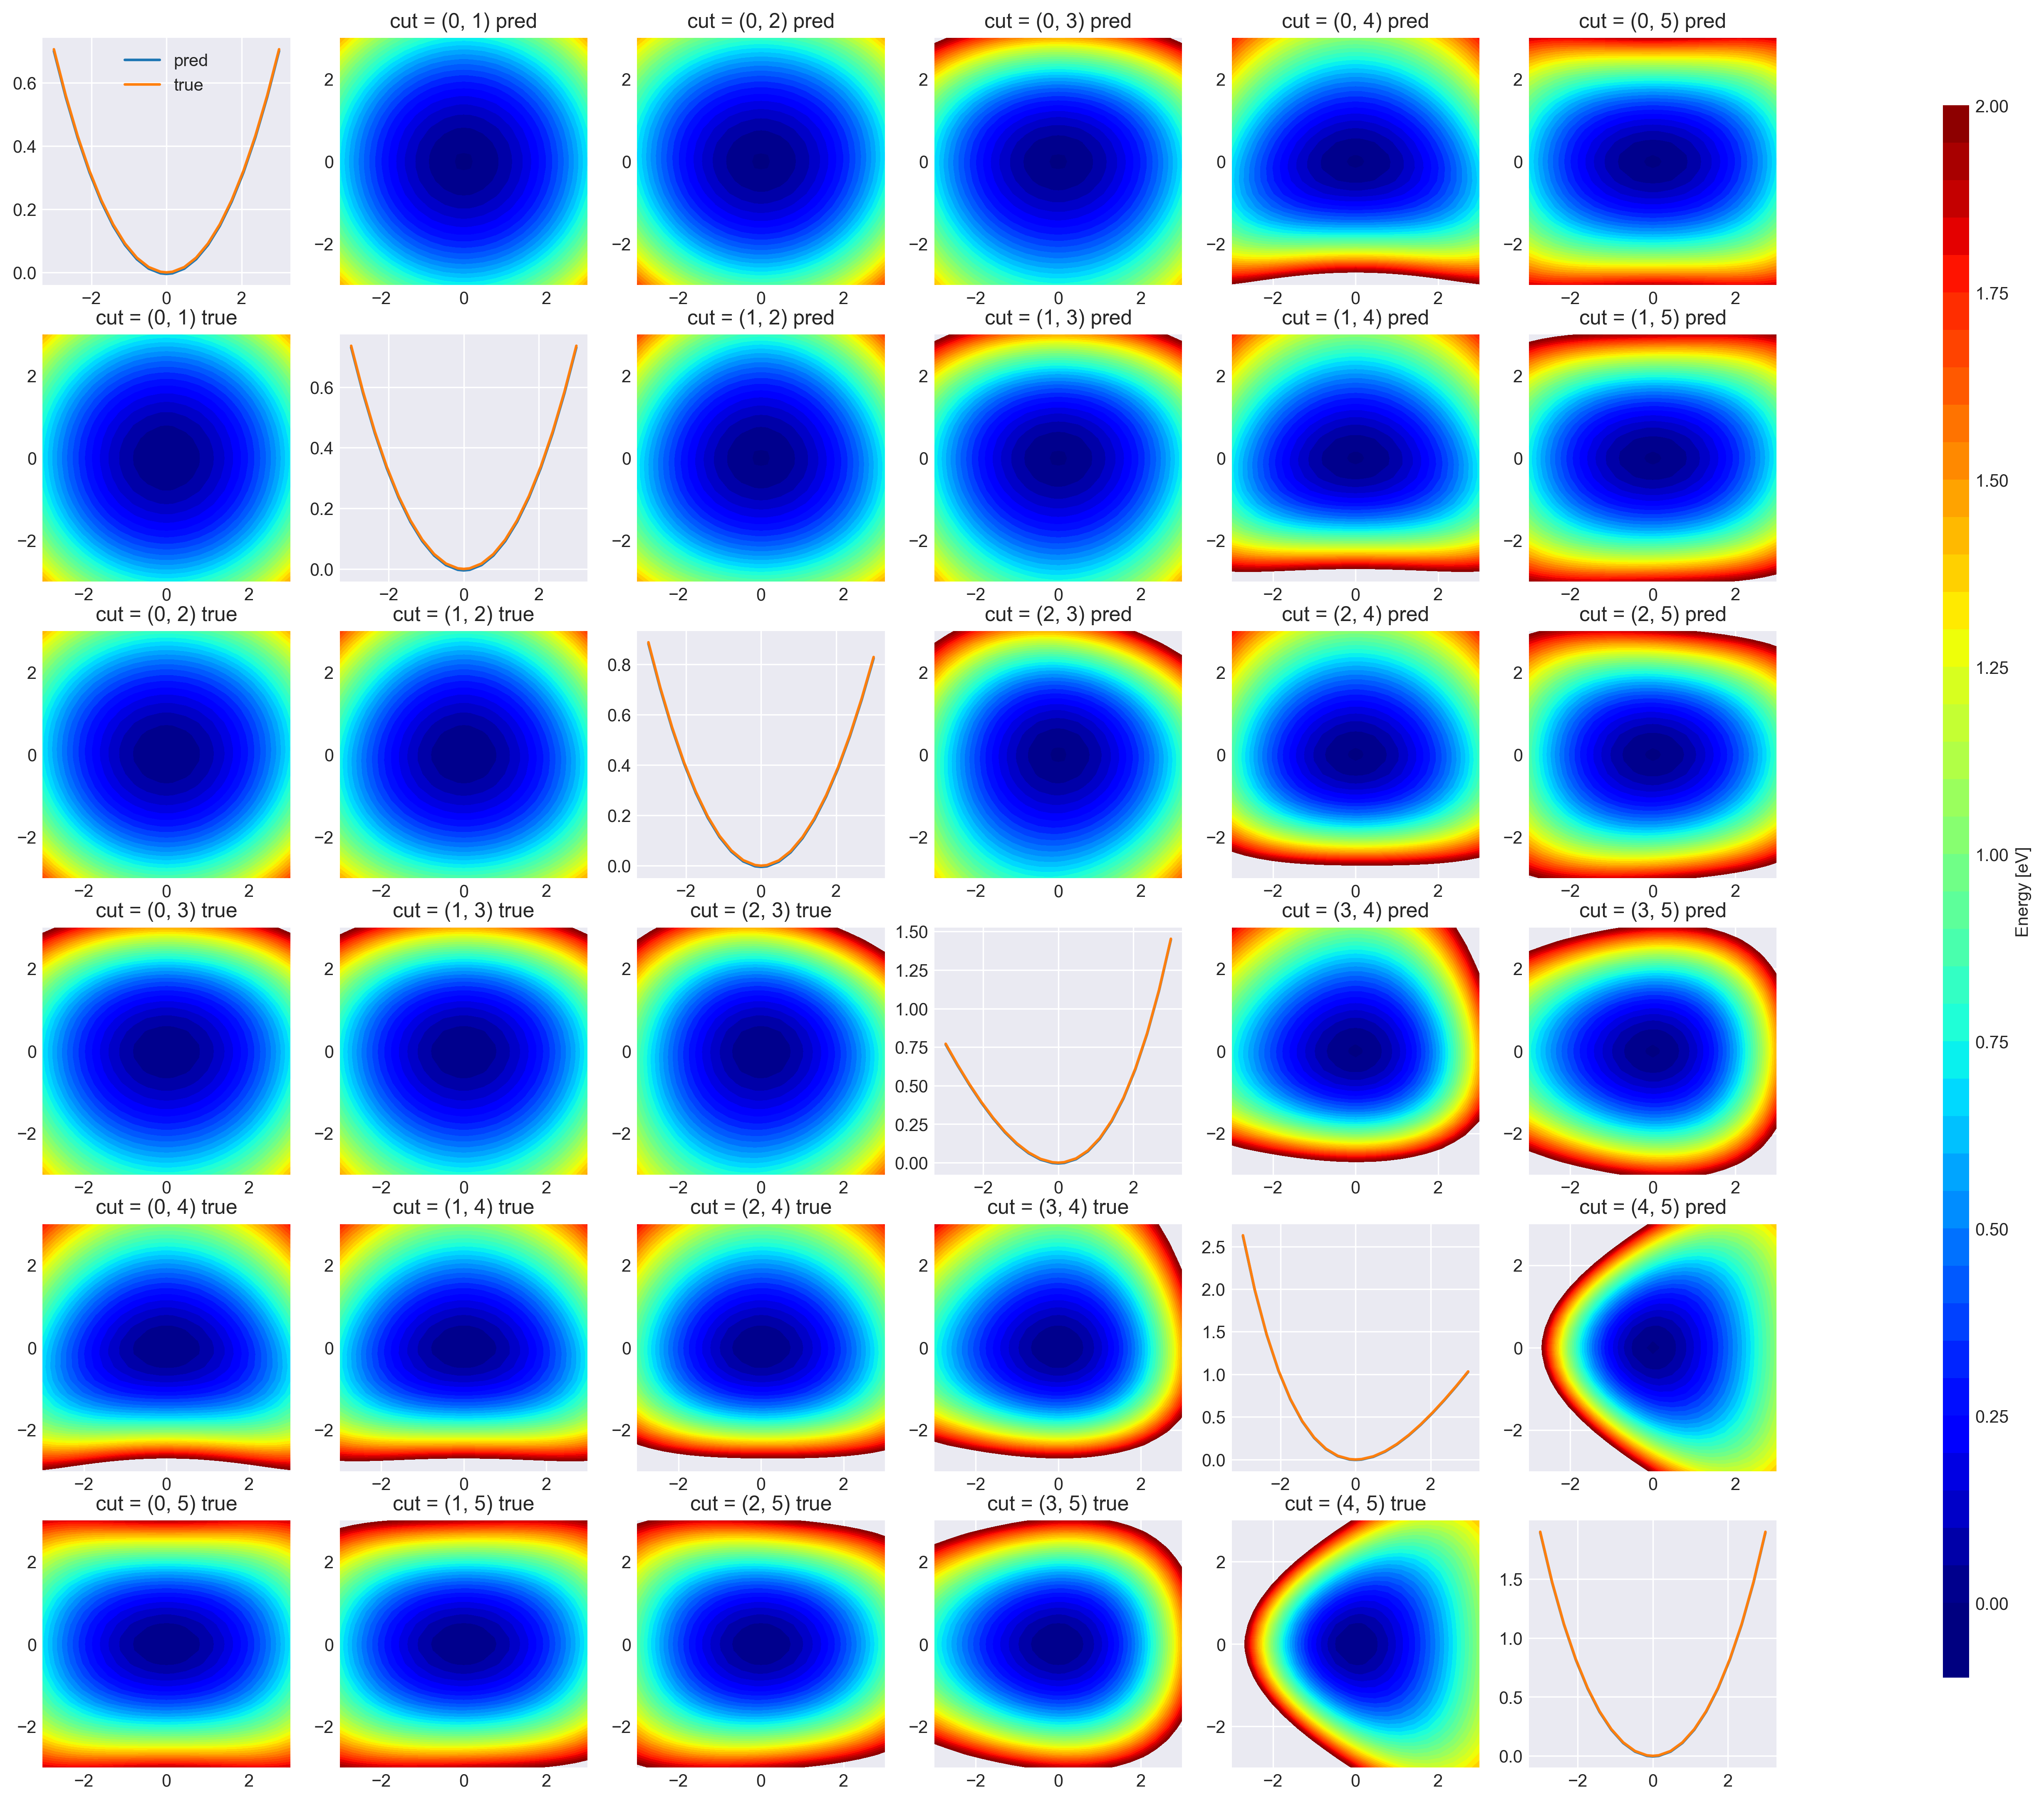

In [4]:
# | code-fold: true
df = pl.read_parquet("data/h2co_dft_2MR.parquet")
n = 6
selected_df = df.filter(  # (pl.col('Q0') == 0) & (pl.col('Q1') == 0) &
    (pl.col("Q2") == 0)
    & (pl.col("Q3") == 0)
    & (pl.col("Q4") == 0)
    & (pl.col("Q5") == 0)
).sort(by=["Q1", "Q0"])

Q0 = np.array(selected_df["Q0"])
Q0 = np.linspace(-3.0, 3.0, 20)
# insert 0.0 in sorted order
Q0 = np.insert(Q0, np.searchsorted(Q0, 0.0), 0.0)
Q1 = np.array(selected_df["Q1"])
Q1 = np.linspace(-3.0, 3.0, 20)
Q1 = np.insert(Q1, np.searchsorted(Q1, 0.0), 0.0)
min_ener = df.filter(
    (pl.col("Q0") == 0)
    & (pl.col("Q1") == 0)
    & (pl.col("Q2") == 0)
    & (pl.col("Q3") == 0)
    & (pl.col("Q4") == 0)
    & (pl.col("Q5") == 0)
)["ener"][0]
y_ref = np.array(selected_df["ener"]).reshape(21, 21) - min_ener


fig = plt.figure(figsize=(3 * n + 3, 3 * n), dpi=300)
subfigs = [
    [fig.add_subplot(n, n + 1, i * (n + 1) + j + 1) for j in range(n)]
    for i in range(n)
]

vmax = 2.0
levels = np.arange(-0.1, 2.05, 0.05)

axs = subfigs[0][1]
im = axs.contourf(
    Q0,
    Q1,
    y_ref,
    50,
    vmax=vmax,
    vmin=0.0,
    levels=levels,
)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax, label="Energy [eV]")

active_modes = set(range(n))
for dims in itertools.combinations(range(n), 2):
    fixed_modes = list(active_modes - set(dims))
    target_modes = list(dims)

    Q0 = np.linspace(-3.0, 3.0, 20)
    Q0 = np.insert(Q0, np.searchsorted(Q0, 0.0), 0.0)

    Q1 = np.linspace(-3.0, 3.0, 20)
    Q1 = np.insert(Q1, np.searchsorted(Q1, 0.0), 0.0)

    Q0, Q1 = np.meshgrid(Q0, Q1)
    x = np.zeros((21 * 21, n))
    x[:, dims[0]] = Q0.flatten() / coef[dims[0]]
    x[:, dims[1]] = Q1.flatten() / coef[dims[1]]

    y = (
        nnmpo.forward(x).reshape(Q0.shape) + y_shift - y_min
    )  # * y_scale# * 27.21138 # Eh to eV
    title = f"cut = {dims} pred"
    axs = subfigs[dims[0]][dims[1]]

    axs.set_yticks([-2, 0, 2])
    axs.set_xticks([-2, 0, 2])
    axs.set_title(title)

    im = axs.contourf(
        Q0,
        Q1,
        y,
        50,
        vmax=vmax,
        vmin=0,
        levels=levels,
    )

for dims in itertools.combinations(range(n), 2):
    fixed_modes = list(active_modes - set(dims))
    target_modes = list(dims)
    selected_df = df.filter(
        (pl.col(f"Q{fixed_modes[0]}") == 0)
        & (pl.col(f"Q{fixed_modes[1]}") == 0)
        & (pl.col(f"Q{fixed_modes[2]}") == 0)
        & (pl.col(f"Q{fixed_modes[3]}") == 0)
    ).sort(by=[f"Q{target_modes[1]}", f"Q{target_modes[0]}"])
    Q0 = np.array(selected_df[f"Q{target_modes[0]}"])
    Q0 = np.linspace(-3.0, 3.0, 20)
    # insert 0.0 in sorted order
    Q0 = np.insert(Q0, np.searchsorted(Q0, 0.0), 0.0)
    Q1 = np.array(selected_df[f"Q{target_modes[1]}"])
    Q1 = np.linspace(-3.0, 3.0, 20)
    Q1 = np.insert(Q1, np.searchsorted(Q1, 0.0), 0.0)

    y = np.array(selected_df["ener"]).reshape(21, 21) - min_ener
    title = f"cut = {dims} true"
    axs = subfigs[dims[1]][dims[0]]

    axs.set_yticks([-2, 0, 2])
    axs.set_xticks([-2, 0, 2])
    axs.set_title(title)

    im = axs.contourf(
        Q0,
        Q1,
        y,
        50,
        vmax=vmax,
        vmin=0,
        levels=levels,
    )

for dim in range(n):
    axs = subfigs[dim][dim]

    axs.clear()
    x = np.zeros((21, n))
    Q0 = np.linspace(-3.0, 3.0, 20)
    Q0 = np.insert(Q0, np.searchsorted(Q0, 0.0), 0.0)
    x[:, dim] = Q0 / coef[dim]

    y = (
        nnmpo.forward(x).reshape(-1) + y_shift - y_min
    )  # * y_scale # * 27.21138 # Eh to eV
    label = "pred" if dim == 0 else None
    axs.plot(Q0, y, label=label)
    Q0 = np.linspace(-3.0, 3.0, 20)
    Q0 = np.insert(Q0, np.searchsorted(Q0, 0.0), 0.0)
    fixed_modes = list(active_modes - set([dim]))
    selected_df = df.filter(
        (pl.col(f"Q{fixed_modes[0]}") == 0)
        & (pl.col(f"Q{fixed_modes[1]}") == 0)
        & (pl.col(f"Q{fixed_modes[2]}") == 0)
        & (pl.col(f"Q{fixed_modes[3]}") == 0)
        & (pl.col(f"Q{fixed_modes[4]}") == 0)
    ).sort(by=[f"Q{dim}"])
    y = np.array(selected_df["ener"]) - min_ener
    label = "true" if dim == 0 else None
    axs.plot(Q0, y, label=label)
    if dim == 0:
        axs.legend()

plt.savefig("data/h2co_2dpes.png")
plt.show()

## Visualize coordinator

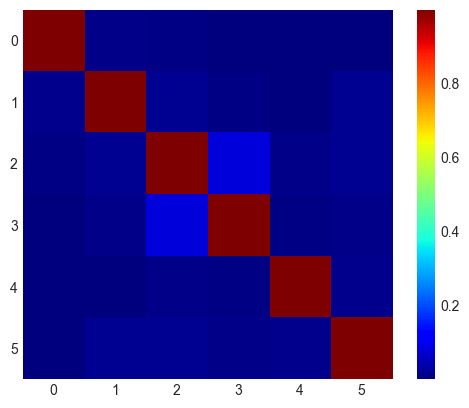

In [5]:
plt.imshow(np.abs(nnmpo.coordinator.U.data))
plt.grid()
plt.colorbar()
plt.show()

- Original displacement vectors

 
<img src='assets/h2co-v1.png' width=150> <img src='assets/h2co-v2.png' width=150> <img src='assets/h2co-v3.png' width=150>
<img src='assets/h2co-v4.png' width=150> <img src='assets/h2co-v5.png' width=150> <img src='assets/h2co-v6.png' width=150>

- Visualize 2D cut of latent DOFs

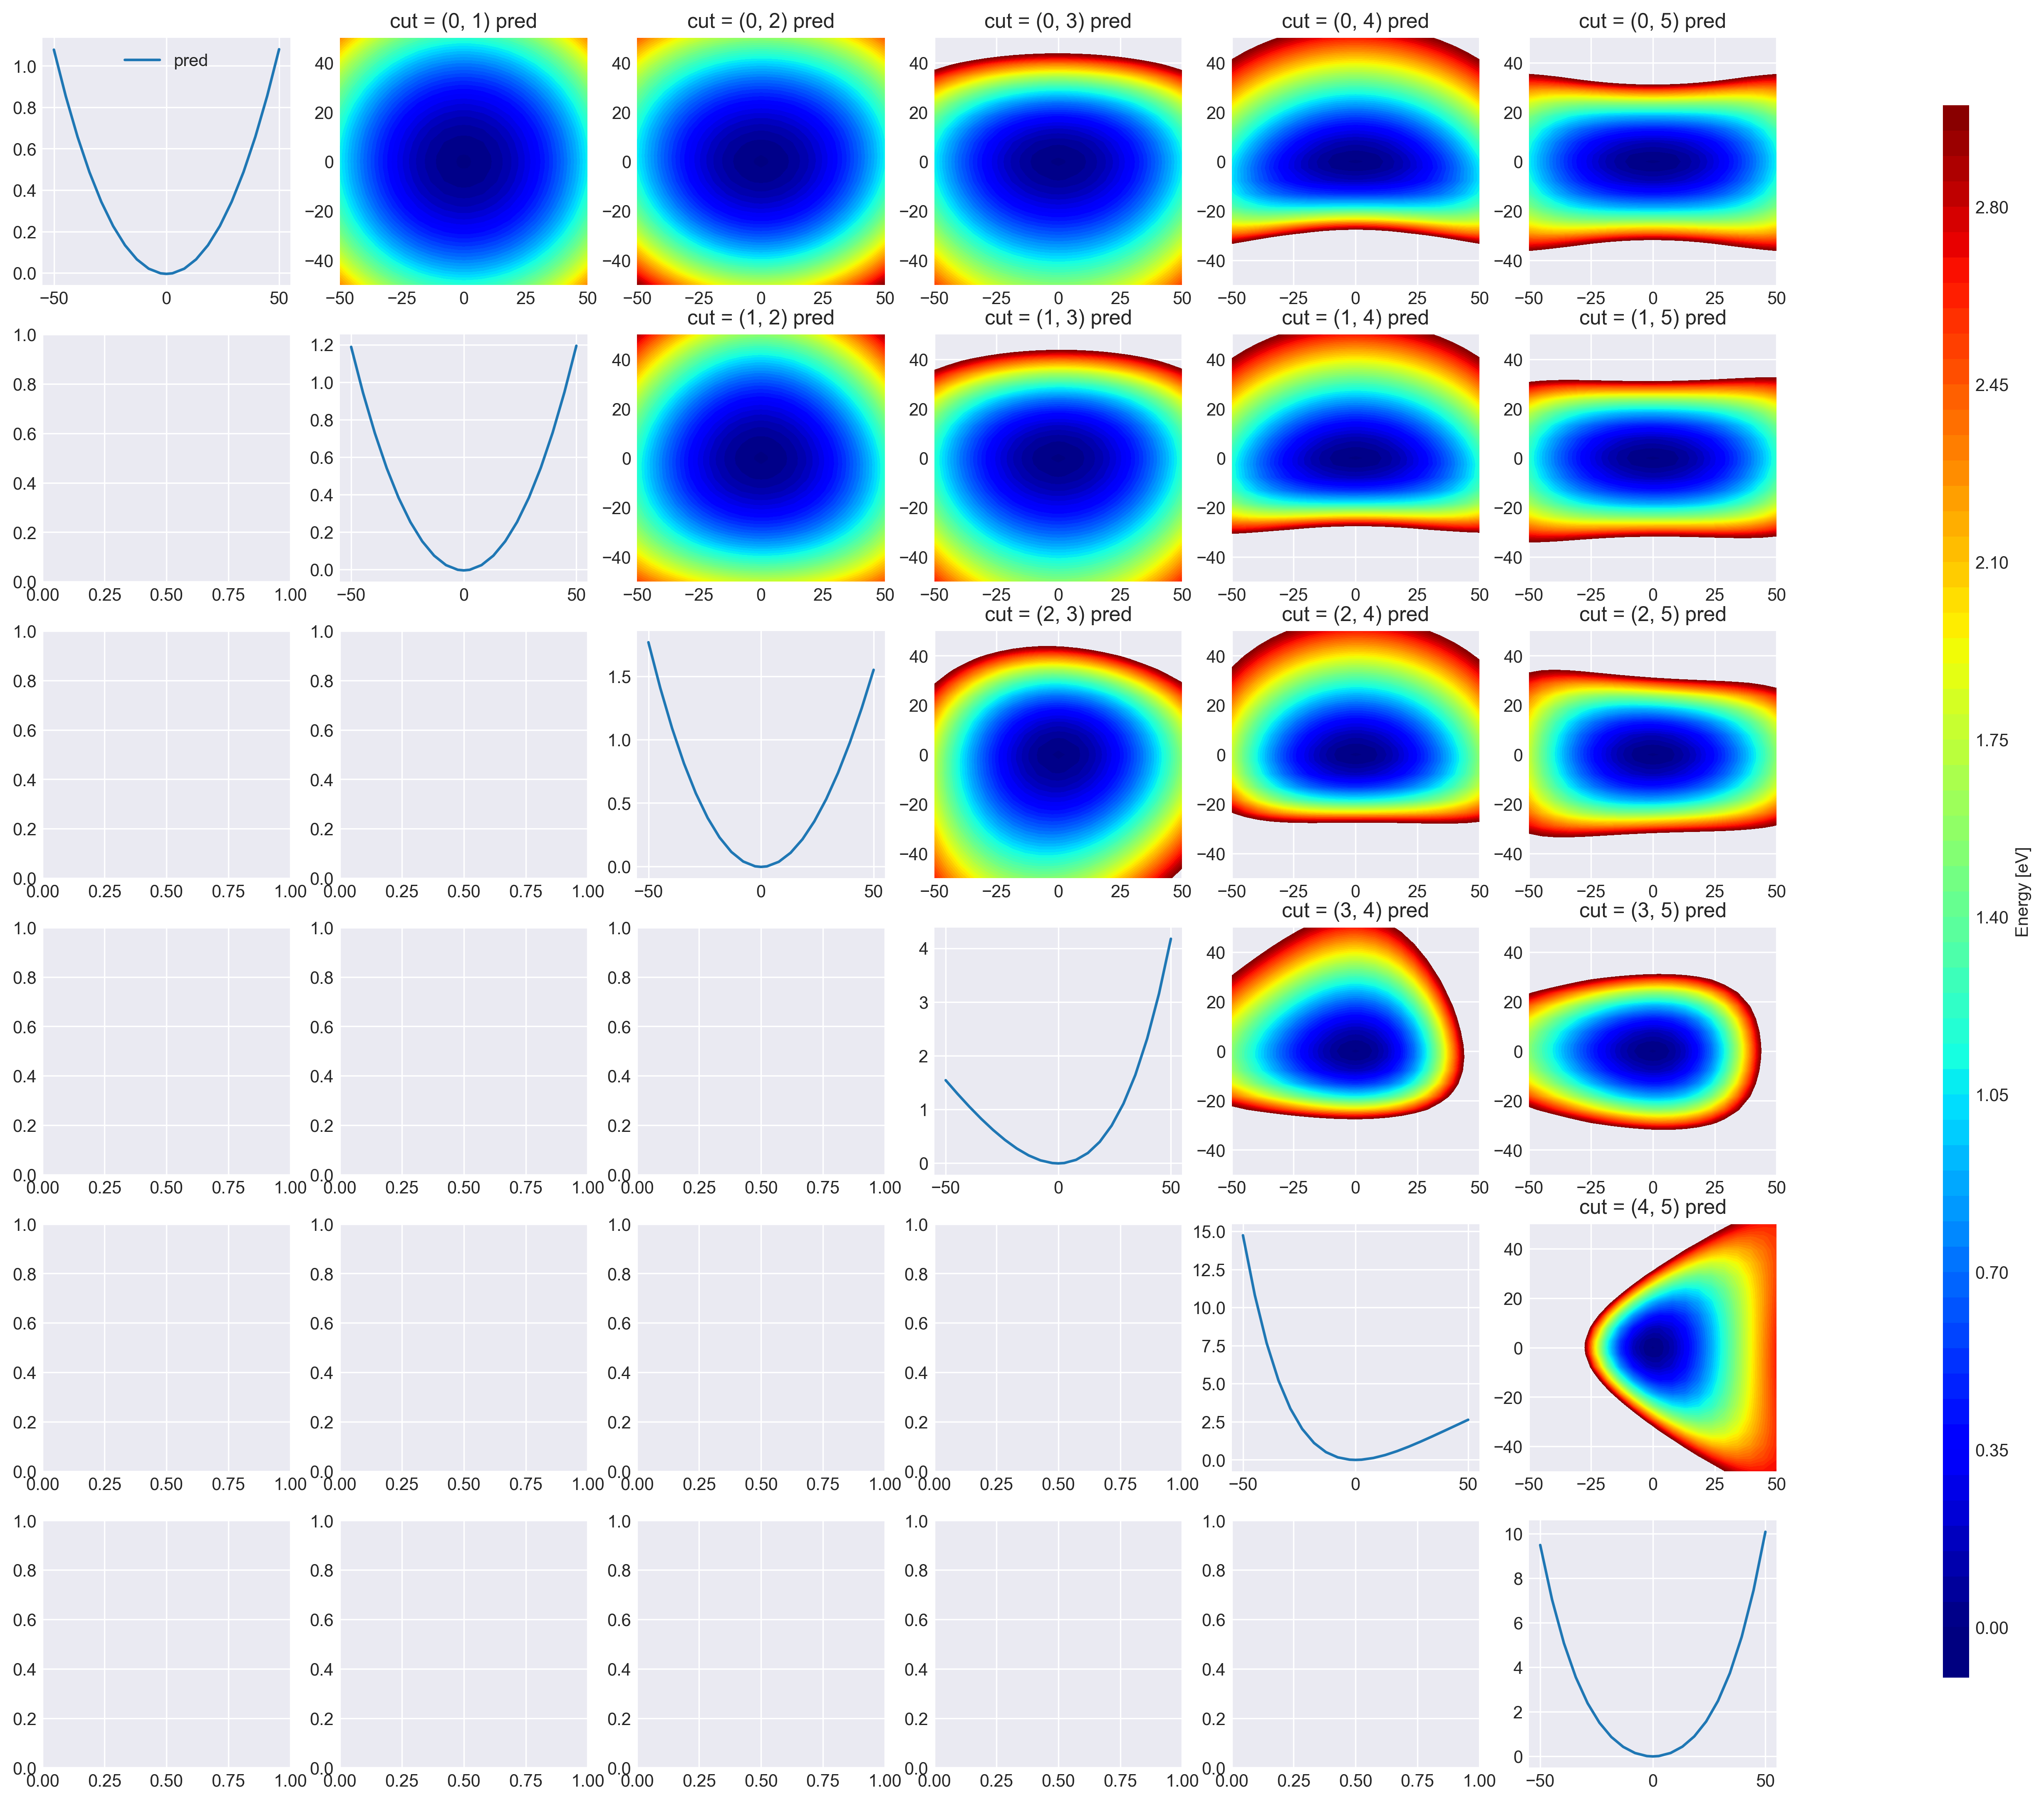

In [6]:
n = 6
fig = plt.figure(figsize=(3 * n + 3, 3 * n), dpi=300)
subfigs = [
    [fig.add_subplot(n, n + 1, i * (n + 1) + j + 1) for j in range(n)]
    for i in range(n)
]

vmax = 3.0
# cmap = "plasma"  #'viridis' # 'RdGy'
levels = np.arange(-0.1, 3.05, 0.05)

axs = subfigs[1][0]  # .subplots()
im = axs.contourf(
    Q0,
    Q1,
    y_ref,
    50,
    vmax=vmax,
    vmin=0.0,
    levels=levels,  # cmap=cmap,
)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax, label="Energy [eV]")

active_modes = set(range(n))
for dims in itertools.combinations(range(n), 2):
    fixed_modes = list(active_modes - set(dims))
    target_modes = list(dims)

    Q0 = np.linspace(-50.0, 50.0, 20)
    Q0 = np.insert(Q0, np.searchsorted(Q0, 0.0), 0.0)

    Q1 = np.linspace(-50.0, 50.0, 20)
    Q1 = np.insert(Q1, np.searchsorted(Q1, 0.0), 0.0)

    Q0, Q1 = np.meshgrid(Q0, Q1)
    x = np.zeros((21 * 21, n))
    x += 0.0  # cut of 10.0
    x[:, dims[0]] = Q0.flatten()
    x[:, dims[1]] = Q1.flatten()
    # x /= x_scale

    y = (
        nnmpo.tt.forward(nnmpo.basis.forward(x, nnmpo.q0)).reshape(Q0.shape)
        + y_shift
        - y_min
    )  # * y_scale
    title = f"cut = {dims} pred"
    axs = subfigs[dims[0]][dims[1]]  # .subplots()

    # axs.set_yticks([-2, 0, 2])
    # axs.set_xticks([-2, 0, 2])
    axs.set_title(title)

    im = axs.contourf(
        Q0,
        Q1,
        y,
        50,
        vmax=vmax,
        vmin=0,
        levels=levels,  # , cmap=cmap
    )

for dim in range(n):
    axs = subfigs[dim][dim]

    axs.clear()
    x = np.zeros((21, n))
    Q0 = np.linspace(-50.0, 50.0, 20)
    Q0 = np.insert(Q0, np.searchsorted(Q0, 0.0), 0.0)
    x[:, dim] = Q0  # / x_scale

    y = (
        nnmpo.tt.forward(nnmpo.basis.forward(x, nnmpo.q0)).reshape(-1)
        + y_shift
        - y_min
    )  # * y_scale
    label = "pred" if dim == 0 else None
    axs.plot(Q0, y, label=label)

    if dim == 0:
        axs.legend()

subfigs[1][0].clear()
plt.savefig("data/h2co_2dpes_latent.png")
plt.show()